In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from plotly import graph_objs as go
import plotly.express as pl
from plotly.subplots import make_subplots
import plotly.offline as pyo
import seaborn as sns


from scipy import stats
#from statsmodels.nonparametric.smoothers_lowess import lowess
#from statsmodels.tsa.stattools import adfuller
#import statsmodels.api as sm


import tensorflow as tf
import keras
import keras.utils
#from pyod.models.auto_encoder import AutoEncoder
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Dense, LSTM, RepeatVector,TimeDistributed
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### Task 1: # Data Loading


#### Input file "machine_0.csv" selected to find the anomaly in machine state

In [2]:
data = pd.read_csv('data/machine_0.csv')
data.columns = ['Time', 'f1', 'f2','f3','f4']
data['Time'] = pd.to_datetime(data['Time'])

data['Time'] = data['Time'].dt.floor('s')
data.head()

Time         f1        f2         f3         f4
0 2019-01-01 00:00:00  12.626096  8.803120 -11.809200  10.083961
1 2019-01-01 08:00:09  10.831994  2.816327  11.554778  21.892853
2 2019-01-01 16:00:19  21.083510 -0.672645 -17.839178  -1.349024
3 2019-01-02 00:00:28  32.294495  6.525132 -13.498586  -4.250752
4 2019-01-02 08:00:38  28.057100  3.691359  21.984744  13.670561

In [5]:
fig = make_subplots(rows = 2, cols=2)
fig.add_trace(go.Scatter(x=data.index, y=data["f1"],name='Feature 1'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["f2"],name='Feature 2'), row=1, col=2)
fig.add_trace(go.Scatter(x=data.index, y=data["f3"],name='Feature 3'), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["f4"],name='Feature 4'), row=2, col=2)

fig.update_layout(title_text='Features')
fig.update_layout(annotations=[ dict(
            x=0.5,
            y=-0.15,
            showarrow=False,
            text="Data Index",
            xref="paper",
            yref="paper"
        ),
        dict(
            x=-0.07,
            y=0.5,
            showarrow=False,
            text="Features Value Range",
            textangle=-90,
            xref="paper",
            yref="paper"
        )
    ])
pyo.iplot(fig)

### Task 2 : Removing Noise from the data 

#### Moving average
This function accepts series and window size and returns moving average of the series with same indices

In [30]:
def ma(series, win_size):
    
    return pd.Series(data=np.convolve(a=series, v=np.ones(int(win_size))/float(win_size), 
                                      mode='same'), index=series.index)

In [31]:
N = 3 # Standard deviation

def threshold(series, lam):
    
    upper = pd.Series(data=(series.mean()+(N*series.std()*(lam/(2-lam))**0.5)),index=series.index)
    lower = pd.Series(data=(series.mean()-(N*series.std()*(lam/(2-lam))**0.5)),index=series.index)
    
    return upper , lower

In [32]:
data_ma= pd.DataFrame()
data_ma['Time'] = data['Time']
data_ma['f1'] = ma(data['f1'],20)
data_ma['f2'] = ma(data['f2'],20)
data_ma['f3'] = ma(data['f3'],20)
data_ma['f4'] = ma(data['f4'],20)
data_ma.head()

Time         f1         f2        f3         f4
0 2019-01-01 00:00:00  13.061998   0.698791  1.274844  -0.407471
1 2019-01-01 08:00:09  26.762524   0.789543  2.266488 -13.447164
2 2019-01-01 16:00:19  27.232547 -11.988773  3.962774 -13.531214
3 2019-01-02 00:00:28  27.635057 -12.354438  3.919560 -14.703468
4 2019-01-02 08:00:38  27.890448   0.155663  4.233751 -15.596987

In [34]:
fig = make_subplots(rows = 4, cols=1)
fig.add_trace(go.Scatter(x=data.index, y=data["f1"],name='Feature 1 ',line = dict( width=1, dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=data_ma.index, y=data_ma["f1"],name='Denoise Feature 1',line = dict(width=2 )), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["f2"],name='Feature 2',line = dict( width=1, dash='dot')), row=2, col=1)
fig.add_trace(go.Scatter(x=data_ma.index, y=data_ma["f2"],name='Denoise Feature 2',line = dict(width=2 )), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["f3"],name='Feature 3',line = dict( width=1, dash='dot')), row=3, col=1)
fig.add_trace(go.Scatter(x=data_ma.index, y=data_ma["f3"],name='Denoise Feature 3',line = dict(width=2 )), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["f4"],name='Feature 4',line = dict( width=1, dash='dot')), row=4, col=1)
fig.add_trace(go.Scatter(x=data_ma.index, y=data_ma["f4"],name='Denoise Feature 4',line = dict(width=2 )), row=4, col=1)
fig.update_layout(title_text='Machine Sensor Data')
fig.update_layout(annotations=[ dict(
            x=0.5,
            y=-0.15,
            showarrow=False,
            text="Data Index",
            xref="paper",
            yref="paper"
        ),
        dict(
            x=-0.07,
            y=0.5,
            showarrow=False,
            text="Features Value Range",
            textangle=-90,
            xref="paper",
            yref="paper"
        )
    ])
fig.show()

In [37]:
data_ma_diff = data_ma.diff(20)
data_ma_diff_thresh_f1= threshold(data_ma_diff['f1'], 0.9)
data_ma_diff_thresh_f2= threshold(data_ma_diff['f2'], 0.9)
data_ma_diff_thresh_f3= threshold(data_ma_diff['f3'], 0.9)
data_ma_diff_thresh_f4= threshold(data_ma_diff['f4'], 0.9)

#individual feature figure

fig_ind = go.Figure()
fig_ind.add_trace(go.Scatter(x=data.index, y=data['f1'], name='Feature 1',
                         line = dict( width=1, dash='dot', color='black')))
fig_ind.add_trace(go.Scatter(x=data.index, y=data_ma['f1'], name='Denoise Feature 1 ',
                         line = dict( width=1,color='blue')))
fig_ind.add_trace(go.Scatter(x=data.index, y=data_ma_diff_thresh_f1[0], name='upper limit',
                         line = dict( width=2, color='red')))
fig_ind.add_trace(go.Scatter(x=data.index, y=data_ma_diff_thresh_f1[1], name='lower limit',
                         line = dict( width=2, color='red')))
fig_ind.update_layout(title_text='Machine Data Feature 1',
                     xaxis_title="Data Index",
                 yaxis_title="Features Value Range"
                 )
fig_ind.show()

In [38]:
data_ma.head()

Time         f1         f2        f3         f4
0 2019-01-01 00:00:00  13.061998   0.698791  1.274844  -0.407471
1 2019-01-01 08:00:09  26.762524   0.789543  2.266488 -13.447164
2 2019-01-01 16:00:19  27.232547 -11.988773  3.962774 -13.531214
3 2019-01-02 00:00:28  27.635057 -12.354438  3.919560 -14.703468
4 2019-01-02 08:00:38  27.890448   0.155663  4.233751 -15.596987

## LSTM Autoencoder Neural Networks

### Task 3 : Creating training and testing dataset

In [40]:
k = data_ma

train_size = int(len(k) * 0.7)
test_size = len(k) - train_size
train , test = k.iloc[0:train_size], k.iloc[train_size:len(k)]
scale = MinMaxScaler()

X_train = np.array(train[['f1','f2','f3','f4']])
X_test = np.array(test[['f1','f2','f3','f4']])

#calculating zscore and training value range is high
X_train = stats.zscore(X_train)
X_test = stats.zscore(X_test)


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### Task 4 : Build an LSTM Autoencoder

In [42]:
def LSTM_NN(X):
    
    input_shape = Input(shape=(X.shape[1], X.shape[2]))
    LL1 = LSTM(128, activation='relu', return_sequences=True, 
               kernel_regularizer=regularizers.l2(0.00))(input_shape)
    LL2 = LSTM(64, activation='relu', return_sequences=False)(LL1)
    LL3 = RepeatVector(X.shape[1])(LL2)
    LL4 = LSTM(64, activation='relu', return_sequences=True)(LL3)
    LL5 = LSTM(128, activation='relu', return_sequences=True)(LL4)
    out = TimeDistributed(Dense(X.shape[2]))(LL5)
    model = Model(inputs=input_shape, outputs = out)
    
    return model

In [49]:
model = LSTM_NN(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 128)            68096     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)             

### Task 5 : Train the Autoencoder

In [51]:
n_epoch = 100
batch = 20
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(X_train, X_train, 
                    epochs=n_epoch, 
                    batch_size = batch,
                    validation_split = 0.05,
                    callbacks = [es],
                    shuffle=False).history

Epoch 1/100
100/100 [==============================] - 2s 15ms/step - loss: 0.7006 - val_loss: 0.6872
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6821 - val_loss: 0.4766
Epoch 3/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6339 - val_loss: 0.4573
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.5953 - val_loss: 0.4075
Epoch 5/100
100/100 [==============================] - 0s 5ms/step - loss: 0.4556 - val_loss: 0.3506
Epoch 6/100
100/100 [==============================] - 1s 5ms/step - loss: 0.3309 - val_loss: 0.2226
Epoch 7/100
100/100 [==============================] - 1s 7ms/step - loss: 0.2745 - val_loss: 0.1897
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 0.2457 - val_loss: 0.1830
Epoch 9/100
100/100 [==============================] - 0s 5ms/step - loss: 0.2330 - val_loss: 0.1959
Epoch 10/100
100/100 [==============================] - 1s 6ms/step - loss: 0.2334 - val_l

### Plot metrics 

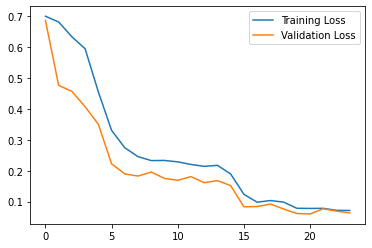

In [52]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend();

### Evaluate the Model

In [53]:
x_pred = model.predict(X_train)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns=['f1', 'f2', 'f3', 'f4'])
x_pred.index = train.index

In [55]:
score = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
score['Loss'] = np.mean(np.abs(x_pred - Xtrain), axis = 1)

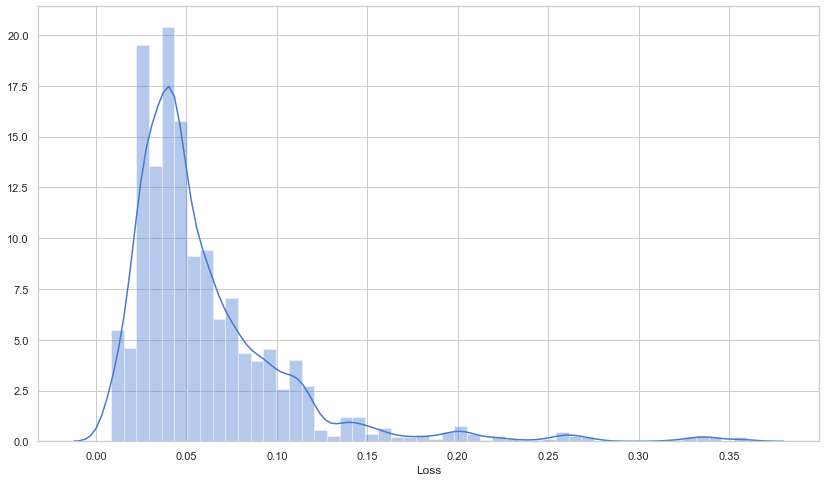

In [56]:
sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

sns.distplot(score['Loss'], bins=50, kde=True);

### Task 6: Setting the Threshold Value

Before a machine fails, it ramps into the faulty mode. Indicating faulty mode with 2 signs
#### 1. Faulty - warning
This indicates warning about machine may be entering in the faulty mode
#### 2. Faulty - Alert 
This indicates that machine is in the faulty mode, necessary actions need to be taken to prevent it from entering in Failed status


##### From the "Loss Distribution"  we can determine the suitable threshold value for identifying the anomalies

In [58]:
#set early warning and critical alert

warn = score['Loss'].max()
warn_thresh = (warn * 0.6).round(3)
alert_thresh = (warn_thresh * 1.8).round(3)
print('Faulty Warning : ' + str(warn_thresh))
print('Faulty Alert :   ' + str(alert_thresh))

Faulty Warning : 0.216
Faulty Alert :   0.389


#### Plot the results to see how the prediction compares with the data

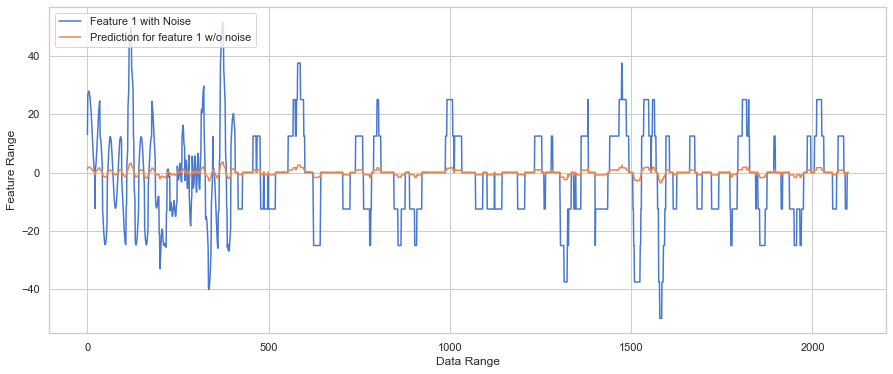

In [60]:
fig = plt.figure(figsize=(15,6))
plt.plot(train['f1'], label='Feature 1 with Noise')
plt.plot(x_pred['f1'], label='Prediction for feature 1 w/o noise')
plt.xlabel('Data Range')
plt.ylabel('Feature Range')
plt.legend(loc='upper left')

### Task 7 : Detect the Anomalies in the Test data

In [61]:
X_test_pred = model.predict(X_test)
X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2])
X_test_pred = pd.DataFrame(X_test_pred, columns=['f1', 'f2', 'f3', 'f4'])
X_test_pred.index = test.index

In [62]:
score_test = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
score_test['Loss'] = np.mean(np.abs(X_test_pred - Xtest), axis = 1)

In [63]:
score_test['Time'] = test['Time']
score_test['f1'] = test['f1']
score_test['f2'] = test['f2']
score_test['f3'] = test['f3']
score_test['f4'] = test['f4']
score_test['warn_thresh'] = warn_thresh 
score_test['alert_thresh']= alert_thresh

score_test.loc[(score_test['Loss']>=warn_thresh)&(score_test['Loss']<alert_thresh),'Mode']='Faulty Warn'  
score_test.loc[(score_test['Loss']>=alert_thresh),'Mode']='Faulty Alert'
score_test.loc[(score_test['Loss']<warn_thresh),'Mode']='Normal'
score_test.head()

Loss                Time        f1         f2         f3        f4  \
2100  0.048052 2020-12-01 05:36:06  0.000736  12.500009  12.501308 -0.000170   
2101  0.026561 2020-12-01 13:36:16  0.000641  -0.000934   0.001762 -0.000429   
2102  0.026564 2020-12-01 21:36:25 -0.000730  -0.000456   0.002275  0.000646   
2103  0.024242 2020-12-02 05:36:35 -0.001390  12.498830   0.002295  0.000369   
2104  0.024242 2020-12-02 13:36:45 -0.002638  12.499958   0.001514 -0.000394   

      warn_thresh  alert_thresh    Mode  
2100        0.216         0.389  Normal  
2101        0.216         0.389  Normal  
2102        0.216         0.389  Normal  
2103        0.216         0.389  Normal  
2104        0.216         0.389  Normal

### Plot the Data and Threshold

In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=score_test.Time, y=score_test.Loss, mode='lines', name='Test loss'))
fig.add_trace(go.Scatter(x=score_test.Time, y=score_test.warn_thresh, mode='lines', name='Warning_Thresh'))
fig.add_trace(go.Scatter(x=score_test.Time, y=score_test.alert_thresh, mode='lines', name='Alert_Thresh'))
fig.update_layout(showlegend=True, title_text='Test Data and corresponding Thresholds',
                 xaxis_title="Time",
                 yaxis_title="Loss Range")
fig.show()

##### This graph visualize the relationship between loss and the thresholds.These loss thresholds filter out the abnormal entries in the data

In [67]:
faulty = score_test[score_test['Mode']=='Faulty Warn']
failed =  score_test[score_test['Mode']=='Faulty Alert']

In [69]:
scaler = StandardScaler()
scaler = scaler.fit(test[['f1']])

### Plot to indicate Faulty Period

The below graph shows the beginning of the faulty period. There are two indications.
##### 1)Fault Warning - 
        At the beginning of the faulty period's warnings will be given(indicated by green markers).
##### 2)Faulty Alert - 
        If the machine is not checked after fault warnings, then fault alert may get generate due to degradation in machine condition(indicated by red markers)


In [76]:
fig_fault = go.Figure()
fig_fault.add_trace(go.Scatter(x=faulty.Time, y=scaler.inverse_transform(faulty.f1), mode='markers',marker=dict(size=10, color='green'), name='Fault Warning'))
fig_fault.add_trace(go.Scatter(x=failed.Time, y=scaler.inverse_transform(failed.f1), mode='markers',marker=dict(size=10, color='red'), name='Fault Alert'))
fig_fault.add_trace(go.Scatter(x=faulty.Time, y=scaler.inverse_transform(faulty.f2), mode='markers',marker=dict(size=10, color='green'), name='Fault Warning'))
fig_fault.add_trace(go.Scatter(x=failed.Time, y=scaler.inverse_transform(failed.f2), mode='markers',marker=dict(size=10, color='red'), name='Fault Alert'))
fig_fault.add_trace(go.Scatter(x=faulty.Time, y=scaler.inverse_transform(faulty.f3), mode='markers',marker=dict(size=10, color='green'), name='Fault Warning'))
fig_fault.add_trace(go.Scatter(x=failed.Time, y=scaler.inverse_transform(failed.f3), mode='markers',marker=dict(size=10, color='red'), name='Fault Alert'))
fig_fault.add_trace(go.Scatter(x=faulty.Time, y=scaler.inverse_transform(faulty.f4), mode='markers',marker=dict(size=10, color='green'), name='Fault Warning'))
fig_fault.add_trace(go.Scatter(x=failed.Time, y=scaler.inverse_transform(failed.f4), mode='markers',marker=dict(size=10, color='red'), name='Fault Alert'))
fig_fault.update_layout(title_text='Time vs Fault warn',xaxis_title="Time",yaxis_title="Feature Range",showlegend=False)
fig_fault.show()

In [74]:
score_test.to_csv('score_output.csv')

##### During regular operation (before Feb 2021), no alerts are triggered. After about Feb 10, 2021, the signal begins to behave differently, and the green color marker is triggered as a warning. Around June, critical end warning is triggered when time series experiences a significant fluctuation. Around May 7, 2021, we can see "Fault warnings" are triggered before and after the "Fault alert warnings", this is because the time series is shown fluctuation after the critical fault alert.


## The approach

##### In this anomaly prediction approach, we have used an autoencoder LSTM architecture. The reasons for using this Model are as follow
##### 1) to Train a model on the machine data when a machine was in a normal state and then determine the anomalies in a while reconstructing data on the test dataset.
##### 2)  Advantage of using LSTM approach is to include multivariate features in the analysis. Computational performance of the other approaches likes "Classification and Regression Trees", "ARIMA" , gets impacted with an increasing number of the features.


##### we have classified the anomalies in 'Low' and 'High' alerts. The Faulty warning points detect the starting point of the 'Faulty' state of the machine. If the machine is still unattended, then the Faulty alert points indicate the high alert that machine immediately needs attention to avoid the Failed state

### Limitation
#####  Performance of this Model is dependent on the training data and the denoising process. Improper denoised training data may affect the sensitivity of the anomaly prediction.

### Other approaches
##### I would like to try anomaly detection using autoencoder methods in H2O

#### Generated output can be view in "score_output.csv", In this csv features(f1,f2,f3,f4) are denoised.
